# Floating Population Data

In [53]:
using DataFrames, CSV, Plots, Wavelets, Clustering
using Distances, LinearAlgebra, Loess, StatsBase, Statistics

include("../../../autocorrelation-shell/src/AutocorrelationShell.jl")
using Main.AutocorrelationShell

In [54]:
float_pop = CSV.read("../data/float_pop_sorted.csv")

,cityname,2019-06-01 10:00:00,2019-06-01 11:00:00,2019-06-01 12:00:00,2019-06-01 13:00:00
,String,Float64,Float64,Float64,Float64
1,Chiyoda,1039.0,1113.0,1245.0,1183.0
2,Chuo,711.0,744.0,839.0,805.0
3,Minato,1031.0,1144.0,1258.0,1192.0
4,Bunkyo,365.0,398.0,459.0,493.0
5,Koutou,727.0,809.0,839.0,786.0
6,Shibuya,889.0,988.0,1166.0,1052.0
7,Shinagawa,613.0,724.0,701.0,625.0
8,Shinjuku,920.0,1022.0,1147.0,1146.0
9,Adachi,549.0,581.0,594.0,594.0


**Note**: Refer to the python notebook for clustering and preprocessing.

## AC2D Transform

In [55]:
H = wavelet(WT.db2)
L = 6
Q = qfilter(H)
P = pfilter(H)

7-element Array{Float64,1}:
 -0.044194173824159244 
 -5.887846720064156e-17
  0.397747564417433    
  0.7071067811865475   
  0.397747564417433    
 -5.887846720064156e-17
 -0.044194173824159244 

In [56]:
X = Matrix(float_pop[2:513])
D = ac2d(X, 1, 1, P, Q)
"muting output"

┌ Warning: `getindex(df::DataFrame, col_inds::Union{AbstractVector, Regex, Not})` is deprecated, use `df[:, col_inds]` instead.
│   caller = top-level scope at In[56]:1
└ @ Core In[56]:1


"muting output"

## Thresholding

### Histogram of Coefficients

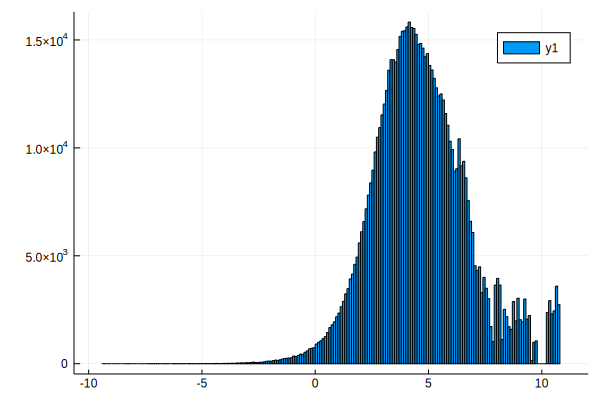

In [57]:
histogram(log.(abs.(D[:])))

The plot above displays the distribution of the absolute log transformed coefficients. Overall, it is a clean bell curve but the right tail of the distribution, where the magnitude of the coefficients become larger, is distorted. We can see that there is a smaller mound on large coefficients that are separated from the main body.

### Large Coefficients

We begin by examining the separate mound of large coefficients by hard thresholding the coefficients at $log(10)$ and reconstructing the signal with the large coefficients alone.

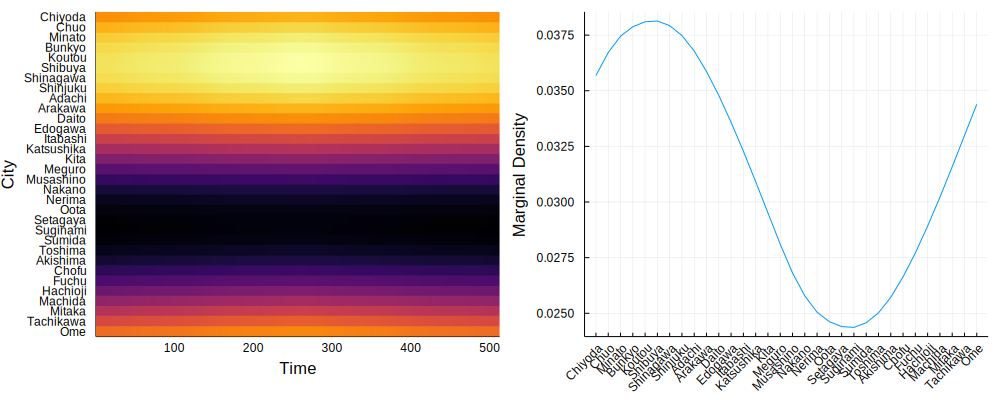

In [71]:
T₁ = acthreshold(D, "hard", exp(10))
R₁ = iac2d(T₁)

h₁ = heatmap(
    R₁, 
    xlabel = "Time",
    ylabel = "City",
    yticks = ([1:1:32;], float_pop[!, :cityname]),
    legend = false, 
    yflip = true
)

p₁ = plot(
    sum(R₁, dims=2)/sum(R₁),
    xlabel = "City",
    ylabel = "Marginal Density",
    xticks = ([1:1:32;], float_pop[!, :cityname]),
    xrotation = 45,
    legend = false
)

plot(h₁, p₁, layout=(1, 2), size=(1000, 400))

The plot on the left shows the heatmap for the reconstructed signal, using only the large coefficients. The plot on the right shows the marginal density for the y axis (City) for the reconstructed signal. We can see that the large coefficients seems to be extracting the trend among cities. However, we must be careful here because, the shape of the marginal density is a very smooth sinusoid curve, which maybe an artifact from the implementation. 

If indeed we made the assumption of periodicity in the implementation, then the large coefficients maybe due to discontinuity, because wavelets produce large coefficients when there suddent jumps within the sigal. Therefore we need to fix the problem of head and tail mismatch.